
# Salary Prediction — Simple Linear Regression

**Anisha Nannapaneni**


## 0) Setup

In [1]:

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))



## 1) Introduction — Problem & Dataset


## 2) Load the Dataset (reads `Salary_Data.csv`)

In [2]:

CSV_PATH = 'Salary_Data.csv'  

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError("Could not find Salary_Data.csv. Download from Kaggle and place it next to this notebook.")

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
display(df.head())
display(df.describe())


Shape: (30, 2)


,YearsExperience,Salary
0,1.1,39343.0
1,1.3,46205.0
2,1.5,37731.0
3,2.0,43525.0
4,2.2,39891.0


,YearsExperience,Salary
count,30.000000,30.000000
mean,5.313333,76003.000000
std,2.837888,27414.429785
min,1.100000,37731.000000
25%,3.200000,56720.750000
50%,4.700000,65237.000000
75%,7.700000,100544.750000
max,10.500000,122391.000000



## 3) What is Regression? (Rubric: 10 pts + bonus math)
**Regression** predicts a continuous target variable (here, salary).  
**Simple Linear Regression** models a linear relationship:
\(
y = \beta_0 + \beta_1 x + \varepsilon
\)
We estimate parameters by minimizing squared error. Closed-form solution:
\(
\hat{\\beta} = (X^TX)^{-1}X^Ty
\)
**RMSE** is used to measure error:
\(
\\text{RMSE} = \\sqrt{\\frac{1}{n}\\sum (y_i - \\hat{y}_i)^2}
\)



## 4) Experiment 1 — Data Understanding


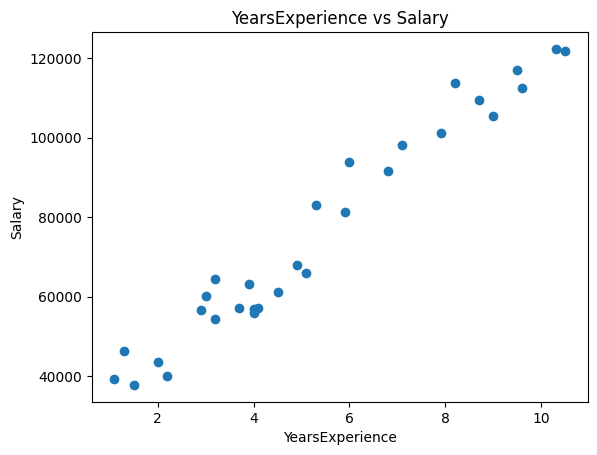

Correlation matrix:


,YearsExperience,Salary
YearsExperience,1.000000,0.978242
Salary,0.978242,1.000000


In [3]:

plt.figure()
plt.scatter(df['YearsExperience'], df['Salary'])
plt.title('YearsExperience vs Salary')
plt.xlabel('YearsExperience')
plt.ylabel('Salary')
plt.show()

corr = df.corr(numeric_only=True)
print("Correlation matrix:")
display(corr)



## 5) Experiment 1 — Pre-processing
This dataset has two numeric columns and no missing values typically. 
- Train/validation split (80/20)
- Standardization for numerical stability


In [4]:

X = df[['YearsExperience']].values
y = df['Salary'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print("Train size:", X_train.shape[0], " | Valid size:", X_valid.shape[0])


Train size: 24  | Valid size: 6



## 6) Experiment 1 — Modeling (Linear Regression)
Baseline **LinearRegression** with standardization.


In [5]:

pipe_lr = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
pipe_lr.fit(X_train, y_train)

pred_lr = pipe_lr.predict(X_valid)
rmse_lr = rmse(y_valid, pred_lr)
r2_lr = r2_score(y_valid, pred_lr)
print("EXP 1 — Linear | RMSE:", rmse_lr, "| R^2:", r2_lr)

cv_scores = cross_val_score(pipe_lr, X, y, cv=5, scoring='neg_root_mean_squared_error')
print("EXP 1 — 5-fold CV RMSE (mean ± std):", -cv_scores.mean(), "±", cv_scores.std())


EXP 1 — Linear | RMSE: 7059.043621901506 | R^2: 0.9024461774180498
EXP 1 — 5-fold CV RMSE (mean ± std): 6527.796603338689 ± 1247.686248345616


### Residual Diagnostics

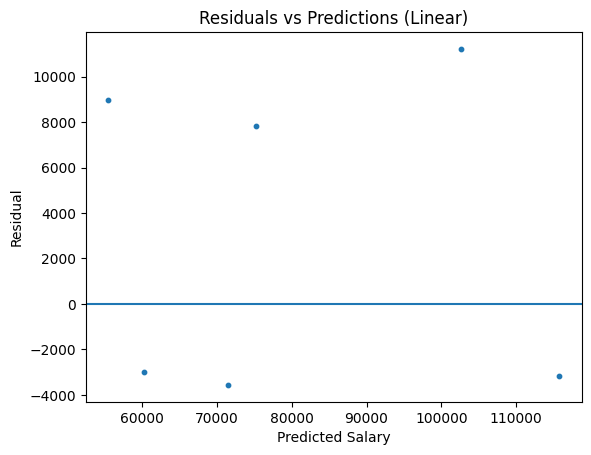

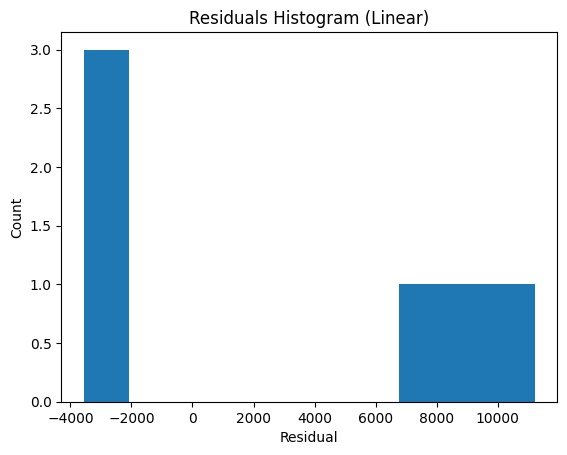

In [6]:

resid = y_valid - pred_lr

plt.figure()
plt.scatter(pred_lr, resid, s=10)
plt.axhline(0)
plt.title('Residuals vs Predictions (Linear)')
plt.xlabel('Predicted Salary'); plt.ylabel('Residual')
plt.show()

plt.figure()
plt.hist(resid, bins=10)
plt.title('Residuals Histogram (Linear)')
plt.xlabel('Residual'); plt.ylabel('Count')
plt.show()



## 7) Experiment 2 — Regularized Linear Models (Ridge & Lasso)


In [7]:

alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

best_rmse_ridge, best_alpha_ridge = float('inf'), None
for a in alphas:
    ridge = Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=a, random_state=RANDOM_STATE))])
    ridge.fit(X_train, y_train)
    pred = ridge.predict(X_valid)
    score = rmse(y_valid, pred)
    if score < best_rmse_ridge:
        best_rmse_ridge, best_alpha_ridge = score, a

best_rmse_lasso, best_alpha_lasso = float('inf'), None
for a in alphas:
    lasso = Pipeline([('scaler', StandardScaler()), ('model', Lasso(alpha=a, random_state=RANDOM_STATE, max_iter=10000))])
    lasso.fit(X_train, y_train)
    pred = lasso.predict(X_valid)
    score = rmse(y_valid, pred)
    if score < best_rmse_lasso:
        best_rmse_lasso, best_alpha_lasso = score, a

print(f"EXP 2 — Ridge best alpha={best_alpha_ridge} | RMSE={best_rmse_ridge}")
print(f"EXP 2 — Lasso best alpha={best_alpha_lasso} | RMSE={best_rmse_lasso}")


EXP 2 — Ridge best alpha=0.001 | RMSE=7059.121628677359
EXP 2 — Lasso best alpha=0.001 | RMSE=7059.043690801179



## 8) Experiment 3 — Polynomial Regression (degree=2,3) 


In [8]:

degrees = [1,2,3]
results_poly = []

for d in degrees:
    poly = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                     ('scaler', StandardScaler()),
                     ('model', LinearRegression())])
    poly.fit(X_train, y_train)
    pred = poly.predict(X_valid)
    results_poly.append((d, rmse(y_valid, pred), r2_score(y_valid, pred)))

results_poly_df = pd.DataFrame(results_poly, columns=['Degree','Valid_RMSE','Valid_R2']).sort_values('Valid_RMSE')
display(results_poly_df)


,Degree,Valid_RMSE,Valid_R2
2,3,6971.787097,0.904843
0,1,7059.043622,0.902446
1,2,7247.614530,0.897165


## 9) Compare All Experiments

In [9]:

summary = pd.DataFrame({
    'Experiment': ['Linear (Std)', 'Ridge (best)', 'Lasso (best)', 'Poly best (by RMSE)'],
    'Valid_RMSE': [rmse_lr, best_rmse_ridge, best_rmse_lasso, results_poly_df.iloc[0]['Valid_RMSE']],
    'Valid_R2':   [r2_lr, np.nan, np.nan, results_poly_df.iloc[0]['Valid_R2']]
})
display(summary.sort_values('Valid_RMSE'))


,Experiment,Valid_RMSE,Valid_R2
3,Poly best (by RMSE),6971.787097,0.904843
0,Linear (Std),7059.043622,0.902446
2,Lasso (best),7059.043691,NaN
1,Ridge (best),7059.121629,NaN



## 10) Impact 
Salary models risk encoding inequities if trained with biased factors (e.g., education, location, demographics). 
Even with a neutral feature like YearsExperience, deploying salary predictors may influence negotiation dynamics and fairness. 
Mitigations: transparency about uncertainty, avoid sensitive attributes, and use human oversight.



## 11) Conclusion
- Linear regression provides a strong baseline with clear interpretability.
- On this tiny dataset, **regularization** may modestly help; **polynomial** terms can overfit—use CV to verify.
- With more data, we’d expand features (role, industry, location) and audit subgroup errors.



## 12) References 
- Kaggle dataset: *Years of experience and Salary dataset* (rohankayan).
- scikit-learn documentation for LinearRegression, Ridge, Lasso, PolynomialFeatures.
- Course notes on regression and RMSE.
